In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Flatten, Dropout
from keras.layers.merge import Dot, multiply, concatenate
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from collections import defaultdict
from tensorflow import keras
#Otro sistema empleado
# Mapea las peliculas en base a su id 
def get_mapping(series):
    occurances = defaultdict(int)
    for element in series:
        occurances[element] += 1
    mapping = {}
    i = 0
    for element in occurances:
        i += 1
        mapping[element] = i

    return mapping

#Se carga los datos 
def get_data():
    data = pd.read_csv("/content/sample_data/ratings.csv")

    mapping_work = get_mapping(data["movieId"])

    data["movieId"] = data["movieId"].map(mapping_work)

    mapping_users = get_mapping(data["movieId"])

    data["movieId"] = data["movieId"].map(mapping_users)

    percentil_80 = np.percentile(data["timestamp"], 80)

    print("percentil_80",percentil_80)

    print("timestamp<80",np.mean(data["timestamp"]<percentil_80))

    print("timestamp>80",np.mean(data["timestamp"]>percentil_80))

    cols = ["userId", "movieId", "rating"]

    train = data[data.timestamp<percentil_80][cols]

    print("train.shape",train.shape)

    test = data[data.timestamp>=percentil_80][cols]

    print("test.shape",test.shape)

    max_user = max(data["userId"].tolist() )
    max_work = max(data["movieId"].tolist() )


    return train, test, max_user, max_work, mapping_work



#Modelo 1
def get_model_1(max_work, max_user):
    dim_embedddings = 30
    bias = 3
    # entradas
    w_inputs = Input(shape=(1,), dtype='int32')
    w = Embedding(max_work+1, dim_embedddings, name="work")(w_inputs)

    # contexto
    u_inputs = Input(shape=(1,), dtype='int32')
    u = Embedding(max_user+1, dim_embedddings, name="user")(u_inputs)
    o = multiply([w, u])
    o = Dropout(0.5)(o)
    o = Flatten()(o)
    o = Dense(8)(o)
    o = Dense(1)(o)

    rec_model = Model(inputs=[w_inputs, u_inputs], outputs=o)
    #rec_model.summary()
    rec_model.compile(loss='mae', optimizer='adam', metrics=["mae", "acc"])

    return rec_model

#Modelo 2
def get_model_2(max_work, max_user):
    dim_embedddings = 30
    bias = 1
    # entrada
    w_inputs = Input(shape=(1,), dtype='int32')
    w = Embedding(max_work+1, dim_embedddings, name="work")(w_inputs)
    w_bis = Embedding(max_work + 1, bias, name="workbias")(w_inputs)

    # contexto
    u_inputs = Input(shape=(1,), dtype='int32')
    u = Embedding(max_user+1, dim_embedddings, name="user")(u_inputs)
    u_bis = Embedding(max_user + 1, bias, name="userbias")(u_inputs)
    o = multiply([w, u])
    o = concatenate([o, u_bis, w_bis])
    o = Dropout(0.5)(o)
    o = Flatten()(o)
    o = Dense(1)(o)

    rec_model = Model(inputs=[w_inputs, u_inputs], outputs=o)
    #rec_model.summary()
    rec_model.compile(loss='mae', optimizer='adam', metrics=["mae", "acc"])

    return rec_model

def get_model_3(max_work, max_user):
    dim_embedddings = 30
    bias = 1

    # entrada
    w_inputs = Input(shape=(1,), dtype='int32')
    w = Embedding(max_work+1, dim_embedddings, name="work")(w_inputs)
    w_bis = Embedding(max_work + 1, bias, name="workbias")(w_inputs)

    # contexto
    u_inputs = Input(shape=(1,), dtype='int32')
    u = Embedding(max_user+1, dim_embedddings, name="user")(u_inputs)
    u_bis = Embedding(max_user + 1, bias, name="userbias")(u_inputs)
    o = multiply([w, u])
    o = Dropout(0.5)(o)
    o = concatenate([o, u_bis, w_bis])
    o = Flatten()(o)
    o = Dense(8, activation='linear')(o)
    o = Dense(10, activation="relu")(o)

    o = Dense(1)(o)

    rec_model = Model(inputs=[w_inputs, u_inputs], outputs=o)
    #rec_model.summary()
    
    rec_model.compile(loss='mae', optimizer=keras.optimizers.Adam(lr=0.001), metrics=["mae", "acc"])

    return rec_model

def get_array(series):
    return np.array([[element] for element in series])

In [ ]:
!pip install utils
!pip install plotly
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
from utils import *
from sklearn.metrics import mean_absolute_error
import pickle

train, test, max_user, max_work, mapping_work = get_data()

print("train", train)
print("test", test)
print("max_user", max_user)
print("max_work", max_work)
print("mapping_work", mapping_work)

In [ ]:
import time

start = time.time()
model = get_model_1(max_work, max_user)

history = model.fit([get_array(train["movieId"]), get_array(train["userId"])], get_array(train["rating"]), nb_epoch=20,
                    validation_split=0.2, verbose=1)

#model.save_weights("model_1.h5")

predictions = model.predict([get_array(test["movieId"]), get_array(test["userId"])])

test_performance = mean_absolute_error(test["rating"], predictions)

print(" Test Mae model 1 : %s " % test_performance)
print("Time finish:",time.time() - start)


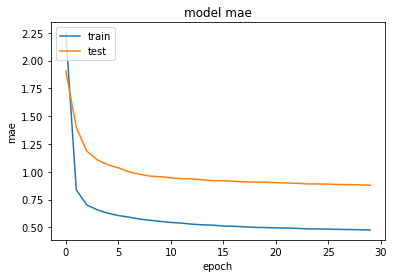

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("model mae")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
start = time.time()
model = get_model_2(max_work, max_user)

history = model.fit([get_array(train["movieId"]), get_array(train["userId"])], get_array(train["rating"]), nb_epoch=100,
                    validation_split=0.2, verbose=1)

predictions = model.predict([get_array(test["movieId"]), get_array(test["userId"])])

test_performance = mean_absolute_error(test["rating"], predictions)

print(" Test Mae model 2 : %s " % test_performance)

print("Time finish:",time.time() - start)

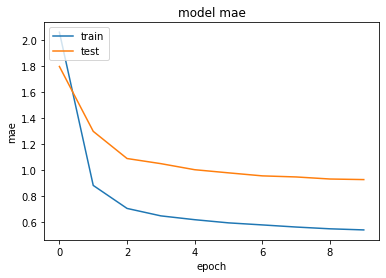

In [ ]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("model mae")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
start = time.time()
model = get_model_3(max_work, max_user)

history = model.fit([get_array(train["movieId"]), get_array(train["userId"])], get_array(train["rating"]), nb_epoch=50,
                    validation_split=0.2, verbose=1)

predictions = model.predict([get_array(test["movieId"]), get_array(test["userId"])])

test_performance = mean_absolute_error(test["rating"], predictions)

print("Test Mae model 3 : %s " % test_performance)

print("Time finish:",time.time() - start)

#Test Mae model 3 : 0.7782244602220487 
#Time finish: 178.79273128509521

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 64534 samples, validate on 16134 samples
Epoch 1/50
64534/64534 [==============================] - 9s 138us/step - loss: 0.8842 - mae: 0.8842 - acc: 0.2916 - val_loss: 0.8402 - val_mae: 0.8402 - val_acc: 0.2405
Epoch 2/50
64534/64534 [==============================] - 9s 138us/step - loss: 0.6252 - mae: 0.6252 - acc: 0.3647 - val_loss: 0.8240 - val_mae: 0.8240 - val_acc: 0.2518
Epoch 3/50
64534/64534 [==============================] - 9s 135us/step - loss: 0.5601 - mae: 0.5601 - acc: 0.4083 - val_loss: 0.8202 - val_mae: 0.8202 - val_acc: 0.2546
Epoch 4/50
64534/64534 [==============================] - 9s 141us/step - loss: 0.5209 - mae: 0.5209 - acc: 0.4323 - val_loss: 0.8163 - val_mae: 0.8163 - val_acc: 0.2562
Epoch 5/50
64534/64534 [==============================] - 9s 136us/step - loss: 0.4995 - mae: 0.4995 - acc: 0.4478 - val_loss: 0.7974 - val_mae: 0.7974 - val_acc: 0.2697
Epoch 6/50
64534/64534 [==============================] - 9s 140us/step - loss: 0.4820 - mae: 0.4820

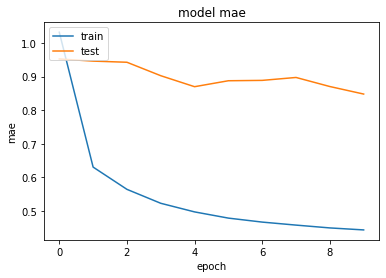

In [ ]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("model mae")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
